## Basic Steps

1. Run a baseline training script to build a speech commands model.
2. Add in your custom word to the training and test/validation sets.
   - Modify labels, shape of your output tensor in the model.
   - Make sure that feature extractor for the model aligns with the feature extractor 
     used in the arduino code.
3. Re-train model. => TF Model using floating-point numbers, that recognizes Google word and custom word.
4. Quantize the model and convert to TFlite. => keyword_model.tflite file
5. Convert tflite to .c file, using xxd => model_data.cc
6. Replace contents of existing micro_features_model.cpp with output of xxd.

All of the above steps are done in this notebook for the commands 'left', 'right'.

7. In micro_speech.ino, modify micro_op_resolver (around line 80) to add any necessary operations (DIFF_FROM_LECTURE)
8. In micro_features_model_settings.h, modify kSilenceIndex and kUnknownIndex, depending on 
where you have them in commands.  
  - Commands = ['left', 'right', '_silence', '_unknown'] => kSilenceIndex=2, kUnknownIndex=3
9. In micro_features_model_settings.cpp, modify kCategoryLabels to correspond to commands in this script.
10. In micro_features_micro_model_settings.h, set kFeatureSliceDurationMs, kFeatureSliceStrideMs to match what is passed to microfrontend as window_size, window_step, respectively.
11. Rebuild Arduino program, run it, recognize the two target words.
12. Experiment with model architecture, training parameters/methods, augmentation, more data-gathering, etc.

*Note*:  As of 5/3/21, this model uses 22% of flash and 49.5% of RAM, so there is substantial space to improve the model, but the latency is about 208ms, which is probably too slow.

In [206]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import Input, layers
from tensorflow.keras import models
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op
print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
# from tqdm import tqdm # replace with this if moving out of notebook

import os
import pathlib

from datetime import datetime as dt

from IPython import display

2.9.1


In [207]:
# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [208]:
i16min = -2**15
i16max = 2**15-1
fsamp = 16000
wave_length_ms = 1000
wave_length_samps = int(wave_length_ms*fsamp/1000)
window_size_ms=60
window_step_ms=40
num_filters = 32
use_microfrontend = True
# dataset = 'mini-speech'
# dataset = 'full-speech-ds' # use the full speech commands as a pre-built TF dataset 
dataset = 'full-speech-files' # use the full speech commands stored as files 

silence_str = "_silence"  
unknown_str = "_unknown"
EPOCHS = 25

In [96]:
((wave_length_ms - window_size_ms) /window_step_ms) + 1


24.5

In [90]:
window_size_ms * fsamp /1000

960.0

model.input.shape[1]

Apply the frontend to an example signal.

In [209]:
commands = ['orange', 'sheila'] 
if dataset == 'mini-speech':
    data_dir = pathlib.Path(os.path.join(os.getenv("HOME"), 'data/mini_speech_commands'))
    if not data_dir.exists():
        tf.keras.utils.get_file('mini_speech_commands.zip',
            origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
            extract=True, cache_dir='.', cache_subdir='data')
  # commands = np.array(tf.io.gfile.listdir(str(data_dir))) # if you want to use all the command words
  # commands = commands[commands != 'README.md']
elif dataset == 'full-speech-files':
    data_dir = pathlib.Path('D:\Datasets\speech_commands_v0.02.tar')
    #data_dir = pathlib.Path(os.path.join(os.getenv("HOME"), 'data/speech_commands_files_0.2'))

elif dataset == 'full-speech-ds':
    raise RuntimeError("full-speech-ds is not really supported yet")

In [210]:
data_dir

WindowsPath('D:/Datasets/speech_commands_v0.02.tar')

In [211]:
label_list = commands.copy()
label_list.insert(0, silence_str)
label_list.insert(1, unknown_str)
print('label_list:', label_list)

label_list: ['_silence', '_unknown', 'orange', 'sheila']


In [7]:
!ls $data_dir/

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [212]:
if dataset == 'mini-speech' or dataset == 'full-speech-files':
    filenames = tf.io.gfile.glob(str(data_dir) + '/*/*.wav') 
    # with the next commented-out line, you can choose only files for words in label_list
    # filenames = tf.concat([tf.io.gfile.glob(str(data_dir) + '/' + cmd + '/*') for cmd in label_list], 0)
    filenames = tf.random.shuffle(filenames)
    num_samples = len(filenames)
    print('Number of total examples:', num_samples)
    # print('Number of examples per label:',
    #       len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
    print('Example file tensor:', filenames[0])

Number of total examples: 110835
Example file tensor: tf.Tensor(b'D:\\Datasets\\speech_commands_v0.02.tar\\seven\\1c3f4fac_nohash_0.wav', shape=(), dtype=string)


In [213]:
filenames
# tf.strings.split(filenames[0], os.path.sep)[-2].numpy().decode('utf8')

<tf.Tensor: shape=(110835,), dtype=string, numpy=
array([b'D:\\Datasets\\speech_commands_v0.02.tar\\seven\\1c3f4fac_nohash_0.wav',
       b'D:\\Datasets\\speech_commands_v0.02.tar\\eight\\61482e52_nohash_2.wav',
       b'D:\\Datasets\\speech_commands_v0.02.tar\\one\\4c6944d6_nohash_1.wav',
       ...,
       b'D:\\Datasets\\speech_commands_v0.02.tar\\six\\879a2b38_nohash_2.wav',
       b'D:\\Datasets\\speech_commands_v0.02.tar\\no\\122c5aa7_nohash_3.wav',
       b'D:\\Datasets\\speech_commands_v0.02.tar\\yes\\b0ae6326_nohash_2.wav'],
      dtype=object)>

In [214]:
# Not really necessary, but just look at a few of the files to make sure that 
# they're the correct files, shuffled, etc.
for i in range(10):
    print(filenames[i].numpy().decode('utf8'))

D:\Datasets\speech_commands_v0.02.tar\seven\1c3f4fac_nohash_0.wav
D:\Datasets\speech_commands_v0.02.tar\eight\61482e52_nohash_2.wav
D:\Datasets\speech_commands_v0.02.tar\one\4c6944d6_nohash_1.wav
D:\Datasets\speech_commands_v0.02.tar\go\94de6a6a_nohash_1.wav
D:\Datasets\speech_commands_v0.02.tar\eight\a6d586b7_nohash_3.wav
D:\Datasets\speech_commands_v0.02.tar\seven\ab46af55_nohash_4.wav
D:\Datasets\speech_commands_v0.02.tar\four\e6327279_nohash_1.wav
D:\Datasets\speech_commands_v0.02.tar\five\0f7dc557_nohash_0.wav
D:\Datasets\speech_commands_v0.02.tar\sheila\b8897f1c_nohash_2.wav
D:\Datasets\speech_commands_v0.02.tar\right\b10b0654_nohash_1.wav


In [215]:
if dataset == 'mini-speech':
    print('Using mini-speech')
    num_train_files = int(0.8*num_samples) 
    num_val_files = int(0.1*num_samples) 
    num_test_files = num_samples - num_train_files - num_val_files
    train_files = filenames[:num_train_files]
    val_files = filenames[num_train_files: num_train_files + num_val_files]
    test_files = filenames[-num_test_files:]
elif dataset == 'full-speech-files':  
  # the full speech-commands set lists which files are to be used
  # as test and validation data; train with everything else
    fname_val_files = os.path.join(data_dir, 'validation_list.txt')    
    with open(fname_val_files) as fpi_val:
        val_files = fpi_val.read().splitlines()
  # validation_list.txt only lists partial paths
    val_files = [os.path.join(data_dir, fn) for fn in val_files]
    val_files = [w.replace('/', '\\') for w in val_files]
    
    #doing the same for custom orange samples in for validation
  #  orange_dir = pathlib.Path(r'C:\Users\user\Documents\School\Spring 2023\Untitled Folder')
  #  name_orange_val_files = os.path.join(orange_dir, 'validation_list.txt')
  #  with open(name_orange_val_files) as fpi_val:
  #      orange_val_files = fpi_val.read().splitlines()
        
  #  orange_val_files = [os.path.join(data_dir, fn) for fn in orange_val_files]
    
    #doing the same for custom orange samples for testing
  #  name_orange_test_files = os.path.join(orange_dir, 'testing_list.txt')
  #  with open(name_orange_test_files) as fpi_val:
  #      orange_test_files = fpi_val.read().splitlines()
        
  #  orange_test_files = [os.path.join(data_dir, fn) for fn in orange_test_files]
    
    #original testing list
    fname_test_files = os.path.join(data_dir, 'testing_list.txt')

    with open(fname_test_files) as fpi_tst:
        test_files = fpi_tst.read().splitlines()
  # testing_list.txt only lists partial paths
    test_files = [os.path.join(data_dir, fn).rstrip() for fn in test_files]
    test_files = [w.replace('/', '\\') for w in test_files]

    #combining orange val with original val
   # print('orange validation set size', len(orange_val_files))
    #print('original validaiton set size', len(val_files))
    #val_files = set(val_files).update(set(orange_val_files))
    #print('validation set size with orange', len(val_files))
    
    #combining orange test with original test
    #print('orange testing set size', len(orange_test_files))
    #print('original validaiton set size', len(test_files))
    #test_files = set(test_files).update(set(orange_test_files))
    #print('validation set size with orange', len(test_files))
    
  # convert the TF tensor filenames into an array of strings so we can use basic python constructs
    train_files = [f.decode('utf8') for f in filenames.numpy()]
  # don't train with the _background_noise_ files; exclude when directory name starts with '_'
    train_files = [f for f in train_files if f.split('\\')[-2][0] != '_']
  # validation and test files are listed explicitly in *_list.txt; train with everything else
    train_files = list(set(train_files) - set(test_files) - set(val_files))
  # now convert back into a TF tensor so we can use the tf.dataset pipeline
    train_files = tf.constant(train_files)    
    print("full-speech-files is in progress.  Good luck!")
elif dataset == 'full-speech-ds':  
    print("Using full-speech-ds. This is in progress.  Good luck!")
else:
    raise ValueError("dataset must be either full-speech-files, full-speech-ds or mini-speech")
print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

full-speech-files is in progress.  Good luck!
Training set size 88843
Validation set size 10480
Test set size 11506


'D:\\Datasets\\speech_commands_v0.02.tar\\validation_list.txt'

In [26]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

In [27]:
# @tf.function
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    in_set = tf.reduce_any(parts[-2] == label_list)
    label = tf.cond(in_set, lambda: parts[-2], lambda: tf.constant(unknown_str))
  # print(f"parts[-2] = {parts[-2]}, in_set = {in_set}, label = {label}")
  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
    return  label # parts[-2]

In [28]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

In [29]:
def get_spectrogram(waveform):
    # Concatenate audio with padding so that all audio clips will be of the 
    # same length (16000 samples)
    zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.int16)
    waveform = tf.cast(0.5*waveform*(i16max-i16min), tf.int16)  # scale float [-1,+1]=>INT16
    equal_length = tf.concat([waveform, zero_padding], 0)
    ## Make sure these labels correspond to those used in micro_features_micro_features_generator.cpp
    spectrogram = frontend_op.audio_microfrontend(equal_length, sample_rate=fsamp, num_channels=num_filters,
                                    window_size=window_size_ms, window_step=window_step_ms)
    return spectrogram


Function to convert each waveform in a set into a spectrogram, then convert those
back into a dataset using `from_tensor_slices`.  (We should be able to use 
`wav_ds.map(get_spectrogram_and_label_id)`, but there is a problem with that process).
   

In [30]:
def create_silence_dataset(num_waves, samples_per_wave, rms_noise_range=[0.01,0.2], silent_label=silence_str):
    # create num_waves waveforms of white gaussian noise, with rms level drawn from rms_noise_range
    # to act as the "silence" dataset
    rng = np.random.default_rng()
    rms_noise_levels = rng.uniform(low=rms_noise_range[0], high=rms_noise_range[1], size=num_waves)
    rand_waves = np.zeros((num_waves, samples_per_wave), dtype=np.float32) # pre-allocate memory
    for i in range(num_waves):
        rand_waves[i,:] = rms_noise_levels[i]*rng.standard_normal(samples_per_wave)
    labels = [silent_label]*num_waves
    return tf.data.Dataset.from_tensor_slices((rand_waves, labels))  

In [51]:
def wavds2specds(waveform_ds, verbose=True):
    wav, label = next(waveform_ds.as_numpy_iterator())
    one_spec = get_spectrogram(wav)
    one_spec = tf.expand_dims(one_spec, axis=0)  # add a 'batch' dimension at the front
    one_spec = tf.expand_dims(one_spec, axis=-1) # add a singleton 'channel' dimension at the back    

    num_waves = 0 # count the waveforms so we can allocate the memory
    for wav, label in waveform_ds:
        num_waves += 1
    print(f"About to create spectrograms from {num_waves} waves")
    spec_shape = (num_waves,) + one_spec.shape[1:] 
    spec_grams = np.nan * np.zeros(spec_shape)  # allocate memory
    labels = np.nan * np.zeros(num_waves)
    idx = 0
    for wav, label in waveform_ds:    
        if verbose and idx % 250 == 0:
            print(f"\r {idx} wavs processed", end='')
        spectrogram = get_spectrogram(wav)
        # TF conv layer expect inputs structured as 4D (batch_size, height, width, channels)
        # the microfrontend returns 2D tensors (freq, time), so we need to 
        spectrogram = tf.expand_dims(spectrogram, axis=0)  # add a 'batch' dimension at the front
        spectrogram = tf.expand_dims(spectrogram, axis=-1) # add a singleton 'channel' dimension at the back
        spec_grams[idx, ...] = spectrogram
        new_label = label.numpy().decode('utf8')
        new_label_id = np.argmax(new_label == np.array(label_list))    
        labels[idx] = new_label_id # for numeric labels
        # labels.append(new_label) # for string labels
        idx += 1
    labels = np.array(labels, dtype=int)
    output_ds = tf.data.Dataset.from_tensor_slices((spec_grams, labels))  
    return output_ds

In [216]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
num_train_files = len(train_files)
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
train_ds = wavds2specds(waveform_ds)

About to create spectrograms from 88843 waves
 88750 wavs processed

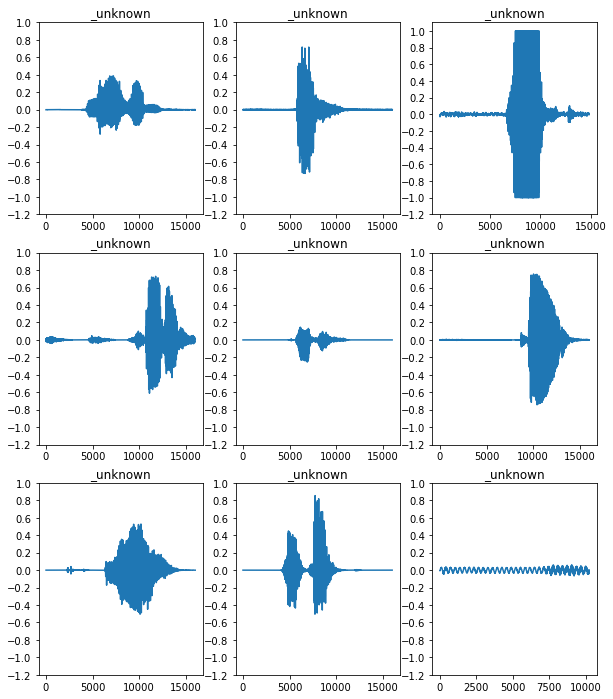

In [217]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

plt.show()

In [218]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: _unknown
Waveform shape: (16000,)
Spectrogram shape: (24, 32)
Audio playback


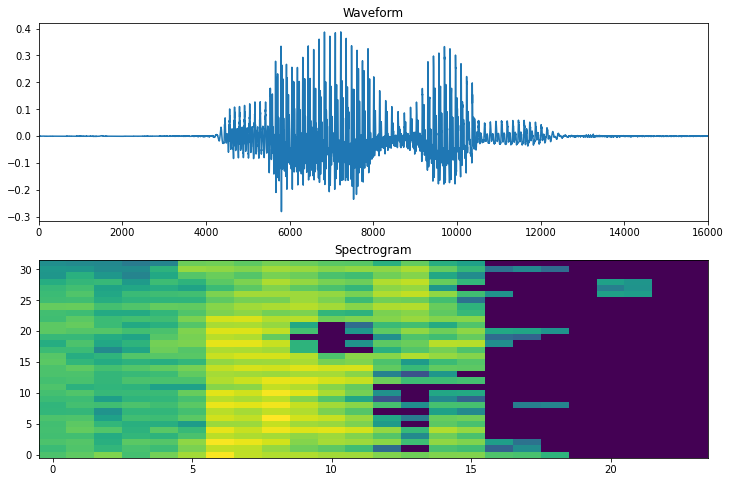

In [219]:
def plot_spectrogram(spectrogram, ax):
    # transpose so that the time is
    # represented in the x-axis (columns).
    freq_bins = spectrogram.shape[1]
    time_dur = spectrogram.shape[0]
    X = np.arange(time_dur)
    Y = range(freq_bins)
    ax.pcolormesh(X, Y, spectrogram.T)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [220]:
spectrogram.numpy().shape

(24, 32)

C:\Users\user\AppData\Local\Temp\ipykernel_2684\2371299125.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ax.set_title(label_list[np.int(label_id)])


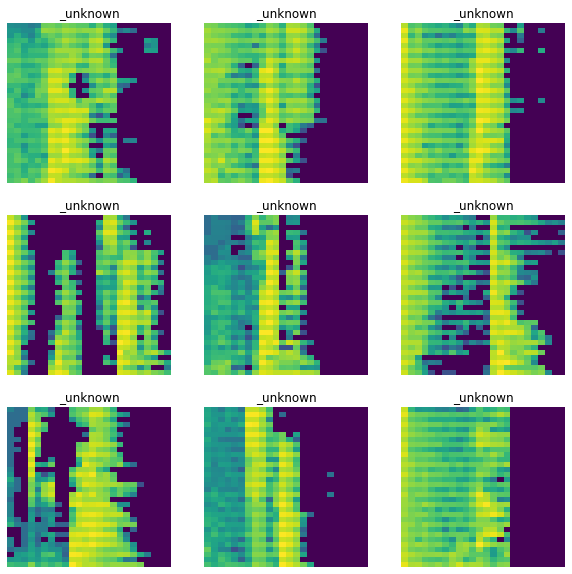

In [221]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(train_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
    ax.set_title(label_list[np.int(label_id)])
    ax.axis('off')

plt.show()

In [222]:
def copy_with_noise(ds_input, rms_level=0.25):
    rng = tf.random.Generator.from_seed(1234)
    wave_shape = tf.constant((wave_length_samps,))
    def add_noise(waveform, label):
        noise = rms_level*rng.normal(shape=wave_shape)
        zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.float32)
        waveform = tf.concat([waveform, zero_padding], 0)    
        noisy_wave = waveform + noise
        return noisy_wave, label

    return ds_input.map(add_noise)

In [223]:
# waveform_ds = augment_with_noise(waveform_ds)
count = 0
for w,l in waveform_ds:
    if w.shape != (16000,):
        print(f"element {count} has shape {w.shape}")
        break
    count += 1
print(count)

element 2 has shape (14861,)
2


In [224]:
def pad_16000(waveform, label):
    zero_padding = tf.zeros([wave_length_samps] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.concat([waveform, zero_padding], 0)        
    return waveform, label

In [225]:
def count_labels(dataset):
    counts = {}
    for _, lbl in dataset:
        if lbl.dtype == tf.string:
            label = lbl.numpy().decode('utf-8')
        else:
            label = lbl.numpy()
        if label in counts:
            counts[label] += 1
        else:
            counts[label] = 1
    return counts

In [63]:
# Collect what we did to generate the training dataset into a 
# function, so we can repeat with the validation and test sets.
def preprocess_dataset(files, num_silent=None, noisy_reps_of_known=None):
  # if noisy_reps_of_known is not None, it should be a list of rms noise levels
  # For every target word in the data set, 1 copy will be created with each level 
  # of noise added to it.  So [0.1, 0.2] will add 2x noisy copies of the target words 
    if num_silent is None:
        num_silent = int(0.2*len(files))+1
    print(f"Processing {len(files)} files")
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    waveform_ds = files_ds.map(get_waveform_and_label)
    if noisy_reps_of_known is not None:
    # create a few copies of only the target words to balance the distribution
    # create a tmp dataset with only the target words
        ds_only_cmds = waveform_ds.filter(lambda w,l: tf.reduce_any(l == commands))
        for noise_level in noisy_reps_of_known:
            waveform_ds = waveform_ds.concatenate(copy_with_noise(ds_only_cmds, rms_level=noise_level))
    if num_silent > 0:
        silent_wave_ds = create_silence_dataset(num_silent, wave_length_samps, 
                                            rms_noise_range=[0.01,0.2], 
                                            silent_label=silence_str)
        waveform_ds = waveform_ds.concatenate(silent_wave_ds)
    print(f"Added {num_silent} silent wavs and ?? noisy wavs")
    num_waves = 0
    output_ds = wavds2specds(waveform_ds)
    return output_ds

In [226]:
print(f"We have {len(train_files)}/{len(val_files)}/{len(test_files)} training/validation/test files")

We have 88843/10480/11506 training/validation/test files


In [227]:
# print(train_files[:20])
print(label_list)
train_files[:20]

tmp_ds = preprocess_dataset(train_files[:20])
print(count_labels(tmp_ds))

with tf.device('/CPU:0'): # needed on M1 mac
    tmp_ds = preprocess_dataset(train_files[:20], noisy_reps_of_known=[0.05,0.1])
    print(count_labels(tmp_ds))



['_silence', '_unknown', 'orange', 'sheila']
Processing 20 files
Added 5 silent wavs and ?? noisy wavs
About to create spectrograms from 25 waves
 0 wavs processed{1: 20, 0: 5}
Processing 20 files
Added 5 silent wavs and ?? noisy wavs
About to create spectrograms from 25 waves
 0 wavs processed{1: 20, 0: 5}


In [233]:
# train_ds is already done
with tf.device('/CPU:0'): # needed on M1 mac
    train_ds = preprocess_dataset(train_files, noisy_reps_of_known=[0.05,0.1,0.15,0.2,0.25])
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Processing 88843 files
Added 17769 silent wavs and ?? noisy wavs
About to create spectrograms from 134642 waves
 134500 wavs processedProcessing 10480 files
Added 2097 silent wavs and ?? noisy wavs
About to create spectrograms from 12577 waves
 12500 wavs processedProcessing 11506 files
Added 2302 silent wavs and ?? noisy wavs
About to create spectrograms from 13808 waves
 13750 wavs processed

In [234]:
print("training data set")
print(count_labels(train_ds))
print("val_ds data set")
print(count_labels(val_ds))
print("test_ds data set")
print(count_labels(test_ds))

training data set
{1: 83237, 3: 9636, 2: 24000, 0: 17769}
val_ds data set
{1: 9777, 3: 204, 2: 499, 0: 2097}
test_ds data set
{1: 10793, 3: 212, 2: 501, 0: 2302}


In [235]:
train_ds = train_ds.shuffle(int(len(train_files)*1.2))
val_ds = val_ds.shuffle(int(len(val_files)*1.2))
test_ds = test_ds.shuffle(int(len(test_files)*1.2))

In [236]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [237]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [238]:
for spectrogram, _ in train_ds.take(1):
    spec1 = spectrogram
# take(1) takes 1 *batch*, so we have to select the first 
# spectrogram from it, hence the [0]
print(f"Spectrogram shape {spec1[0].shape}")
print(f"ranges from {np.min(spec1)} to {np.max(spec1)}")   # min/max across the whole batch

Spectrogram shape (24, 32, 1)
ranges from 0.0 to 712.0


In [239]:
for spectrogram, _ in train_ds.take(1):
  # take(1) takes 1 *batch*, so we have to select the first 
  # spectrogram from it, hence the [0]
    input_shape = spectrogram[0].shape  
print('Input shape:', input_shape)
num_labels = len(label_list)


Input shape: (24, 32, 1)


In [128]:
print('Input shape:', input_shape)
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(20, 3, activation='relu'),
    layers.MaxPooling2D(name='pool2'),
    layers.DepthwiseConv2D(kernel_size=(3,3), padding='same'),
    layers.Conv2D(32, 1, activation='relu'),
    layers.MaxPooling2D(pool_size=(4,4)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_labels),
], name="simple_cnn")

model.summary()

Input shape: (24, 32, 1)
Model: "simple_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 22, 30, 20)        200       
                                                                 
 pool2 (MaxPooling2D)        (None, 11, 15, 20)        0         
                                                                 
 depthwise_conv2d_12 (Depthw  (None, 11, 15, 20)       200       
 iseConv2D)                                                      
                                                                 
 conv2d_18 (Conv2D)          (None, 11, 15, 32)        672       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 2, 3, 32)         0         
 2D)                                                             
                                                                 
 dropout_15 (Dropout)        (N

In [130]:
print('Input shape:', input_shape)
model2 = models.Sequential([
    layers.Input(shape=input_shape),

    layers.Conv2D(20, 3, activation='relu'),
    layers.MaxPooling2D(name='pool2'),

# remove this conv2d layer if error occurs
    layers.Conv2D(20, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.DepthwiseConv2D(kernel_size=(3,3), padding='same'),
    layers.BatchNormalization(),
    layers.DepthwiseConv2D(kernel_size=(3,3), padding='same'),
    layers.BatchNormalization(),
    layers.DepthwiseConv2D(kernel_size=(3,3), padding='same'),
    layers.BatchNormalization(),
    layers.DepthwiseConv2D(kernel_size=(3,3), padding='same'),
    layers.BatchNormalization(),
    
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(pool_size=(4,4)),
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_labels),
], name="Onkar_cnn")

model2.summary()

Input shape: (24, 32, 1)


ValueError: Exception encountered when calling layer "max_pooling2d_13" (type MaxPooling2D).

Negative dimension size caused by subtracting 4 from 2 for '{{node max_pooling2d_13/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 4, 4, 1], padding="VALID", strides=[1, 4, 4, 1]](Placeholder)' with input shapes: [?,2,4,32].

Call arguments received by layer "max_pooling2d_13" (type MaxPooling2D):
  • inputs=tf.Tensor(shape=(None, 2, 4, 32), dtype=float32)

In [136]:
print('Input shape:', input_shape)
model3 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(name='pool2'),
    layers.BatchNormalization(),
    
    layers.DepthwiseConv2D(kernel_size=(3,3), padding='same'),
    layers.Conv2D(32, 1, activation='relu'),
    layers.MaxPooling2D(pool_size=(4,4)),
    
    layers.Conv2D(32, 1, activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),
    
    layers.Conv2D(16, 1, activation='relu'),
    #layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Conv2D(16, 1, activation='relu'),
    #layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Conv2D(8, 1, activation='relu'),
    #layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Conv2D(8, 1, activation='relu'),
    #layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Conv2D(8, 1, activation='relu'),
    #layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Conv2D(16, 1, activation='relu'),
    #layers.MaxPooling2D(),
    layers.BatchNormalization(),
    layers.Conv2D(32, 1, activation='relu'),
    #layers.MaxPooling2D(),
    layers.BatchNormalization(),
    
    
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_labels),
], name="simple_cnn")

model3.summary()

Input shape: (24, 32, 1)
Model: "simple_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 22, 30, 32)        320       
                                                                 
 pool2 (MaxPooling2D)        (None, 11, 15, 32)        0         
                                                                 
 batch_normalization_26 (Bat  (None, 11, 15, 32)       128       
 chNormalization)                                                
                                                                 
 depthwise_conv2d_26 (Depthw  (None, 11, 15, 32)       320       
 iseConv2D)                                                      
                                                                 
 conv2d_47 (Conv2D)          (None, 11, 15, 32)        1056      
                                                                 
 max_pooling2d_30 (MaxPoolin  (

In [185]:
inputs = Input(shape=input_shape)
# put the result of the first Conv in 'y' instead of 'x', so we can access it later to add, creating the skip connection
y = layers.Conv2D(16, kernel_size=(3,3), activation='relu', name='Conv1')(inputs)

x = layers.Conv2D(32, kernel_size=(3,3), strides=(2,2), activation='relu', name='Conv2', padding="same")(y)
x = layers.Dropout(0.1)(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(32, kernel_size=(3,3), strides=(2,2), activation='relu', name='Conv3', padding="same")(x)
x = layers.Dropout(0.1)(x)
x = layers.BatchNormalization()(x)

# Add in our skip connnection, but first we need to reshape 'y' so it can be added to 'x'
# Note that again we're putting the result in 'y' so we can access it for the skip connection
y = layers.Conv2D(32, kernel_size=(1,1), strides=(4,4), name='SkipConvA')(y)
y = layers.add((x,y))

x = layers.Conv2D(32, kernel_size=(3,3), activation='relu', name='Conv4', padding="same")(y)
x = layers.Dropout(0.1)(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(32, kernel_size=(3,3), activation='relu', name='Conv5', padding="same")(x)
x = layers.Dropout(0.1)(x)
x = layers.BatchNormalization()(x)

# another add layer to complete the 2nd skip connection, but this time our layers (Conv4, Conv5)
# did not change the shape, so we don't need to change the shape like we did with SkipConvA
y = layers.add((x,y))

x = layers.Conv2D(75, kernel_size=(3,3), activation='relu', name='Conv6')(y)
x = layers.Conv2D(75, kernel_size=(3,3), activation='relu', name='Conv7')(x)
x = layers.Flatten(name='Flat')(x)
out = layers.Dense(4,name='Dense1')(x)
model4 = tf.keras.Model(inputs=inputs, outputs=out)

model4.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_32 (InputLayer)          [(None, 24, 32, 1)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 22, 30, 16)   160         ['input_32[0][0]']               
                                                                                                  
 Conv2 (Conv2D)                 (None, 11, 15, 32)   4640        ['Conv1[0][0]']                  
                                                                                                  
 dropout_83 (Dropout)           (None, 11, 15, 32)   0           ['Conv2[0][0]']                  
                                                                                            

In [240]:
inputs = Input(shape=input_shape)
# put the result of the first Conv in 'y' instead of 'x', so we can access it later to add, creating the skip connection
y = layers.Conv2D(16, kernel_size=(3,3), activation='relu', name='Conv1')(inputs)

x = layers.Conv2D(32, kernel_size=(3,3), strides=(2,2), activation='relu', name='Conv2', padding="same")(y)
x = layers.Dropout(0.1)(x)
x = layers.BatchNormalization()(x)
x = layers.DepthwiseConv2D(kernel_size=(3,3), padding='same')(x)

x = layers.Conv2D(32, kernel_size=(3,3), strides=(2,2), activation='relu', name='Conv3', padding="same")(x)
x = layers.Dropout(0.1)(x)
x = layers.BatchNormalization()(x)
x = layers.DepthwiseConv2D(kernel_size=(3,3), padding='same')(x)

# Add in our skip connnection, but first we need to reshape 'y' so it can be added to 'x'
# Note that again we're putting the result in 'y' so we can access it for the skip connection
y = layers.Conv2D(32, kernel_size=(1,1), strides=(4,4), name='SkipConvA')(y)
y = layers.add((x,y))

x = layers.Conv2D(32, kernel_size=(3,3), activation='relu', name='Conv4', padding="same")(y)
x = layers.Dropout(0.1)(x)
x = layers.BatchNormalization()(x)
x = layers.DepthwiseConv2D(kernel_size=(3,3), padding='same')(x)

x = layers.Conv2D(32, kernel_size=(3,3), activation='relu', name='Conv5', padding="same")(x)
x = layers.Dropout(0.1)(x)
x = layers.BatchNormalization()(x)
x = layers.DepthwiseConv2D(kernel_size=(3,3), padding='same')(x)

# another add layer to complete the 2nd skip connection, but this time our layers (Conv4, Conv5)
# did not change the shape, so we don't need to change the shape like we did with SkipConvA
#y = layers.Conv2D(1, kernel_size=(1,1), activation = 'relu', padding='same')(y)
y = layers.add((x,y))

x = layers.Conv2D(32, kernel_size=(3,3), activation='relu', name='Conv6')(y)
x = layers.Dropout(0.1)(x)
x = layers.BatchNormalization()(x)

x = layers.Conv2D(32, kernel_size=(3,3), activation='relu', name='Conv7')(x)
x = layers.Dropout(0.1)(x)
x = layers.BatchNormalization()(x)

x = layers.Flatten(name='Flat')(x)
out = layers.Dense(4,name='Dense1')(x)
model5 = tf.keras.Model(inputs=inputs, outputs=out)

model5.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 24, 32, 1)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 22, 30, 16)   160         ['input_35[0][0]']               
                                                                                                  
 Conv2 (Conv2D)                 (None, 11, 15, 32)   4640        ['Conv1[0][0]']                  
                                                                                                  
 dropout_99 (Dropout)           (None, 11, 15, 32)   0           ['Conv2[0][0]']                  
                                                                                           

In [266]:
model.summary()
print('Input shape:', input_shape)
model6 = models.Sequential([
    
    layers.Input(shape=input_shape),
    
    layers.DepthwiseConv2D(kernel_size=(3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    
    layers.DepthwiseConv2D(kernel_size=(3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    
    layers.DepthwiseConv2D(kernel_size=(3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    
    layers.DepthwiseConv2D(kernel_size=(3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    
    layers.DepthwiseConv2D(kernel_size=(3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    
    layers.DepthwiseConv2D(kernel_size=(3,3), padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(num_labels),
], name="smallGuy_cnn")

model6.summary()

Model: "simple_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 22, 30, 32)        320       
                                                                 
 pool2 (MaxPooling2D)        (None, 11, 15, 32)        0         
                                                                 
 batch_normalization_26 (Bat  (None, 11, 15, 32)       128       
 chNormalization)                                                
                                                                 
 depthwise_conv2d_26 (Depthw  (None, 11, 15, 32)       320       
 iseConv2D)                                                      
                                                                 
 conv2d_47 (Conv2D)          (None, 11, 15, 32)        1056      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 2, 3, 32)         0

In [46]:
# number of MACs in each layer is (# outputs in layer) * (number of inputs that contribute to one output)
macs = np.array([(14*38*20)*(3*3), (7*19*20)*(3*3), (7*19*32)*20, 128*128, 128*128, 4*128])
print(macs)
print(np.sum(macs))

[95760 23940 85120 16384 16384   512]
238100


In [267]:
model6.compile( #change model
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [161]:
print(model)
print(model.input)
print(model.layers[4].output)

KerasTensor(type_spec=TensorSpec(shape=(None, 24, 32, 1), dtype=tf.float32, name='input_15'), name='input_15', description="created by layer 'input_15'")
KerasTensor(type_spec=TensorSpec(shape=(None, 11, 15, 32), dtype=tf.float32, name=None), name='conv2d_47/Relu:0', description="created by layer 'conv2d_47'")


model

In [105]:
#  Google: feature extraction with Keras
feature_model = tf.keras.Model(inputs=model.input, outputs= model.layers[4].output)
feature_model

In [108]:
feature_model.save('featureModel', overwrite=False)

INFO:tensorflow:Assets written to: featureModel\assets


INFO:tensorflow:Assets written to: featureModel\assets


In [268]:
history = model6.fit( #change model
    train_ds, 
    validation_data=val_ds,  
    epochs=25) 
    # callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2))

Epoch 1/25
2104/2104 [==============================] - 57s 26ms/step - loss: 0.4623 - accuracy: 0.8323 - val_loss: 0.1457 - val_accuracy: 0.9637
Epoch 2/25
2104/2104 [==============================] - 53s 25ms/step - loss: 0.3129 - accuracy: 0.8847 - val_loss: 0.1153 - val_accuracy: 0.9702
Epoch 3/25
2104/2104 [==============================] - 55s 26ms/step - loss: 0.2866 - accuracy: 0.8952 - val_loss: 0.1418 - val_accuracy: 0.9707
Epoch 4/25
2104/2104 [==============================] - 55s 26ms/step - loss: 0.2747 - accuracy: 0.8994 - val_loss: 0.1823 - val_accuracy: 0.9432
Epoch 5/25
2104/2104 [==============================] - 54s 25ms/step - loss: 0.2620 - accuracy: 0.9036 - val_loss: 0.1101 - val_accuracy: 0.9804
Epoch 6/25
2104/2104 [==============================] - 67s 32ms/step - loss: 0.2577 - accuracy: 0.9057 - val_loss: 0.0840 - val_accuracy: 0.9849
Epoch 7/25
2104/2104 [==============================] - 67s 32ms/step - loss: 0.2505 - accuracy: 0.9070 - val_loss: 0.0764 -

In [269]:
date_str = dt.now().strftime("%d%b%Y_%H%M").lower()
model_file_name = f"kws_ufe_{date_str}.h5" 
print(f"Saving model to {model_file_name}")
model6.save(model_file_name, overwrite=False) #change model

Saving model to kws_ufe_05may2023_0129.h5


In [270]:
with open(model_file_name.split('.')[0] + '.txt', 'w') as fpo:
    fpo.write(f"i16min            = {i16min           }\n")
    fpo.write(f"i16max            = {i16max           }\n")
    fpo.write(f"fsamp             = {fsamp            }\n")
    fpo.write(f"wave_length_ms    = {wave_length_ms   }\n")
    fpo.write(f"wave_length_samps = {wave_length_samps}\n")
    fpo.write(f"window_size_ms    = {window_size_ms   }\n")
    fpo.write(f"window_step_ms    = {window_step_ms   }\n")
    fpo.write(f"num_filters       = {num_filters      }\n")
    fpo.write(f"use_microfrontend = {use_microfrontend}\n")
    fpo.write(f"label_list        = {label_list}\n")
    fpo.write(f"spectrogram_shape = {spectrogram.numpy().shape}\n")


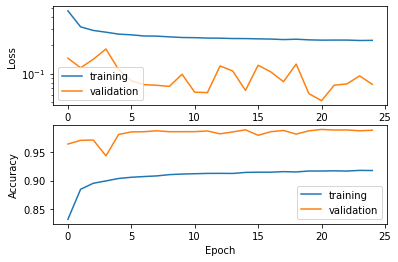

In [271]:
metrics = history.history
plt.subplot(2,1,1)
plt.semilogy(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.subplot(2,1,2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [272]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [273]:
y_pred = np.argmax(model6.predict(test_audio), axis=1) #change model
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

432/432 [==============================] - 3s 7ms/step
Test set accuracy: 99%


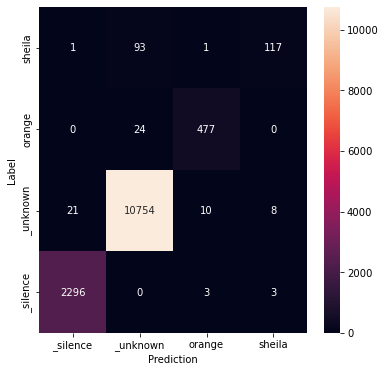

In [274]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.gca().invert_yaxis() # flip so origin is at bottom left
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

On training set:
4208/4208 [==============================] - 28s 7ms/step
Data set accuracy: 93%


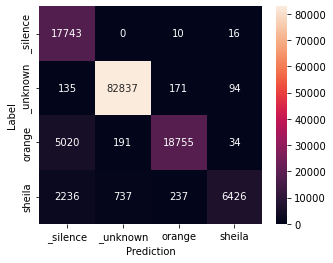

In [275]:
dset = train_ds.unbatch()
print("On training set:")

ds_audio = []
ds_labels = []

for audio, label in dset:
    ds_audio.append(audio.numpy())
    ds_labels.append(label.numpy())

ds_labels = np.array(ds_labels)
ds_audio = np.array(ds_audio)

model_out = model6.predict(ds_audio) #change model
y_pred = np.argmax(model_out, axis=1)
y_true = ds_labels

ds_acc = sum(y_pred == y_true) / len(y_true)
print(f'Data set accuracy: {ds_acc:.0%}')

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(5,4))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Processing 4 files
Added 1 silent wavs and ?? noisy wavs
About to create spectrograms from 5 waves
 0 wavs processed

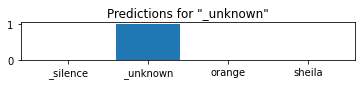

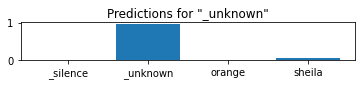

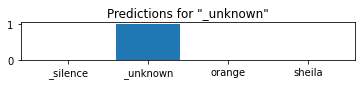

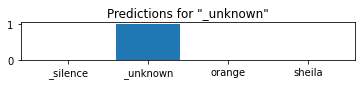

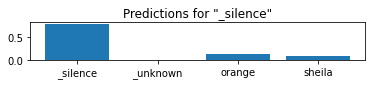

In [83]:
sample_files = [data_dir/'left/07ad9b59_nohash_0.wav', 
                data_dir/'no/01bb6a2a_nohash_0.wav',  
                data_dir/'right/0362539c_nohash_1.wav',
                data_dir/'right/b5d1e505_nohash_0.wav']
fstr_list = [str(f) for f in sample_files]
sample_ds = preprocess_dataset(fstr_list, num_silent=1)
count = 1
for spectrogram, label in sample_ds.batch(1):
    prediction = model(spectrogram)
    plt.subplot(len(sample_files)+1, 1, count)
    plt.bar(label_list, tf.nn.softmax(prediction[0]))
    plt.title(f'Predictions for "{label_list[label[0]]}"')
    plt.show()
    count += 1

## Quantize and Convert to TFLite

In [276]:
converter = tf.lite.TFLiteConverter.from_keras_model(model6) #change model
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [277]:
num_calibration_steps = 10
ds_iter = val_ds.unbatch().batch(1).as_numpy_iterator()
def representative_dataset_gen():
    for _ in range(num_calibration_steps):
        next_input = next(ds_iter)[0]
        next_input = next_input.astype(np.float32)  # (DIFF_FROM_LECTURE)
        yield [next_input]

In [278]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # or tf.uint8; should match dat_q in eval_quantized_model.py
converter.inference_output_type = tf.int8  # or tf.uint8

In [279]:
tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmpf2l_e09v\assets


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmpf2l_e09v\assets
C:\Users\user\anaconda3\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [280]:
fname = 'Conv_model.tflite'
with open(fname, "wb") as fpo:
    num_bytes_written = fpo.write(tflite_quant_model)
print(f"Wrote {num_bytes_written} / {len(tflite_quant_model)} bytes to tflite file")

Wrote 61352 / 61352 bytes to tflite file


In [62]:
!xxd -i kws_model.tflite >! kws_model.cc

'xxd' is not recognized as an internal or external command,
operable program or batch file.
